# BBBC010 dataset for ShapeEmbed
Here, we demonstrate how to prepare the BBBC010 dataset for use with ShapeEmbed. We start with importing relevant libraries and the provided `helpers` module.

In [1]:
import re
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from helpers import *

## Download the dataset
We download the dataset using the provided `get_dataset` helper function. It takes care of downloading and extracting the BBBC010 dataset from [https://bbbc.broadinstitute.org/BBBC010](https://bbbc.broadinstitute.org/BBBC010).

In [2]:
get_dataset()

https://data.broadinstitute.org/bbbc/BBBC010/BBBC010_v1_foreground_eachworm.zip: 100%|█████████████████████████████████████████████████████████████████| 2.61M/2.61M [00:33<00:00, 81.0kB/s]


The dataset is downloaded under `data/BBBC010_v1_foreground_eachworm.zip` and extracted under `data/BBBC010_v1_foreground_eachworm`.

## Prepare the dataset
We then prepare the dataset for the next preprocessing steps. Each image in the dataset is a `.png` file with a name of the form `r'[ABCDE]([0-9]{2})_[0-9]{2}_ground_truth.png'`. As describe on [the dataset's webpage](https://bbbc.broadinstitute.org/BBBC010), the first 2-digits indicates the column of the sample, which tells whether the worms are treated with ampicillin (`alive` for columns `0` to `12`) or not (`dead` for columns `13` to `24`). We will first prepare a `samples` list pairing each image with its label (`0` for 'alive', `1` for 'dead').

In [4]:
ds_path = Path('data/BBBC010_v1_foreground_eachworm')
worm_re = re.compile(r'[ABCDE]([0-9]{2})_[0-9]{2}_ground_truth.png')

# record the path and the label (0: 'alive', 1: 'dead') of each sample
samples = []
# for each image in the dataset, prepare the image path and class
for f in Path(ds_path).iterdir():
  m = worm_re.match(f.name) # match the file name
  if not m: continue # skip files which don't match
  col = int(m.groups(0)[0])
  if col >= 1 and col < 13: samples.append((f, 0))
  elif col >= 13 and col < 25: samples.append((f, 1))
  else: print(f"skipped {f}, unexpected column {col}")

We now have a list of samples together with their respective `0` (alive) or `1` (dead) labels.

In [5]:
n_alive = len([_ for _, lbl in samples if lbl == 0])
n_dead = len([_ for _, lbl in samples if lbl == 1])
print(f'Found {n_alive} alive samples and {n_dead} dead samples')

Found 768 alive samples and 639 dead samples


## Isolate contours
For each of our image, we want to extract the contour of the object isolated in it. Our images are already segmented images, that is, they are binary masks with object pixels all white and background pixels all black. Here we show a sample image of an 'alive' worm.

sample 42, label: 0 -- (0: 'alive', 1: 'dead')


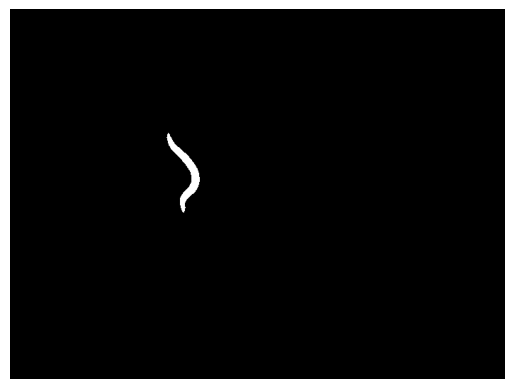

In [6]:
# pick a sample for display purposes
idx_smpl = 42
f_smpl, lbl_smpl = samples[idx_smpl]
img_smpl = Image.open(f_smpl)

print(f"sample {idx_smpl}, label: {lbl_smpl} -- (0: 'alive', 1: 'dead')")

plt.imshow(img_smpl, cmap = 'gray')
plt.axis('off')
plt.show()

We are going to isolate a set of points (with their `(x, y)` coordinates) to represent the contour of the worm. To do so, we will make use of two provided helper functions: `find_longest_contour` and `contour_spline_resample`.

In [7]:
def imageToContour(fname, n_samples = 64, resample_sparsity = 1):
  with Image.open(fname) as img: # open the image for further processing
    arr = np.array(img) # convert the image to a numpy array
    cont = find_longest_contour(arr) # extract the (longest if several) object contour
  # uniformly resample the contour to a desired number of samples along a fitted spline
  return contour_spline_resample( cont
                                , n_samples = n_samples
                                , sparsity = resample_sparsity )

In [8]:
# gather contours by applying our imageToContour function to the samples (and preserve labels as well)
samples_contour = [ (imageToContour(f), lbl) for f, lbl in samples ]

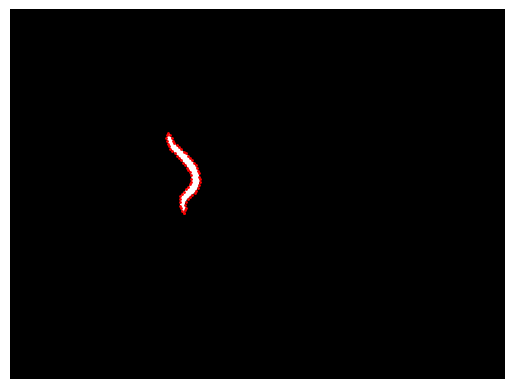

In [9]:
cont_smpl, _ = samples_contour[idx_smpl]

plt.imshow(img_smpl, cmap = 'gray')
plt.axis('off')
plt.scatter(cont_smpl[:, 1], cont_smpl[:, 0], s = 1, facecolor = 'red')
plt.show()

## Convert to distance matrices
Now that we have the contours of the objects as a set of `(x, y)` coordinates, we can turn them into distance matrices for use by ShapeEmbed. We use the provided `distance_matrix` re-exported from the `scipy.spatial` library by our `helpers` module. It takes a set of point coordinates and derive a matrix of distances between points.

In [10]:
# gather distance matrices
samples_dm = [ (distance_matrix(c, c), lbl) for c, lbl in samples_contour ]

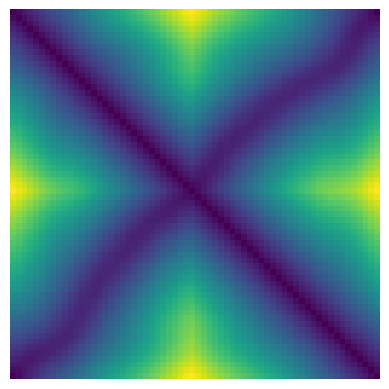

In [11]:
dm_smpl, _ = samples_dm[idx_smpl]

plt.imshow(dm_smpl)
plt.axis('off')
plt.show()

## Split our samples into two train / test sets
We will turn our `samples_dm` list into two `_train` and `_test` lists with respectively `80%` and `20%` of the available data. We will use the `train_test_split` function from the `sklearn` module to achieve this in a stratified manner (keeping the `80%`/`20%` split accross labels).

In [12]:
# isolate the distance matrices `X` and the labels `y`
X = [dm for dm, _ in samples_dm]
y = [lbl for _, lbl in samples_dm]

# stratified split, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y
  , test_size = 0.2
  , stratify = y
  , random_state = 42
)

# recombine distance matrices and labels
samples_dm_train = list(zip(X_train, y_train))
samples_dm_test = list(zip(X_test, y_test))

## Save the distance matrices to disk for use as a `torch` `DatasetFolder`
Now that we have our distance matrices ready, we save them on disk for use by ShapeEmbed. We will create a `_train` folder and a `_test` folder each with a `alive` and a `dead` subfolder. The files contained in the subfolders will be the `.npy` numpy arrays for the distance matrices. This folder structure is compatible with the `torch` [`DatasetFolder`](https://docs.pytorch.org/vision/main/generated/torchvision.datasets.DatasetFolder.html#datasetfolder) class in use by ShapeEmbed.

In [16]:
# given a path on disk and a list of (distance matrix, label) pairs, dump the dataset to disk
def save_distance_matrices(root_path, dms):
  # create the folder hierarchy
  root_path.mkdir(exist_ok = True, parents = True)
  (root_path / 'alive').mkdir(exist_ok = True, parents = True)
  (root_path / 'dead').mkdir(exist_ok = True, parents = True)
  # dump each sample to disk in the appropriate folder
  for idx, (dm, lbl) in enumerate(dms):
    lbl_folder = 'alive' if lbl == 0 else 'dead'
    np.save(root_path / lbl_folder / f'sample_{idx}.npy', dm)

In [17]:
ds_train_path = ds_path.with_stem(ds_path.stem + "_dm_train")
ds_test_path = ds_path.with_stem(ds_path.stem + "_dm_test")

save_distance_matrices(ds_train_path, samples_dm_train)
save_distance_matrices(ds_test_path, samples_dm_test)

The two splits of the dataset are now available at `data/BBBC010_v1_foreground_eachworm_dm_train` and `data/BBBC010_v1_foreground_eachworm_dm_test`.